In [2]:
import sys
sys.path.append('path/of/AI-Advanced-Course')

In [3]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/AI-Advanced-Course-master')


Mounted at /content/drive


In [4]:
import imp

from matplotlib import pyplot as plt

try:
    imp.find_module('jupyterplot')
    from jupyterplot import ProgressPlot
except ImportError:
    !pip install jupyterplot
    from jupyterplot import ProgressPlot

     |████████████████████████████████| 71kB 7.7MB/s 
  Created wheel for lrcurve: filename=lrcurve-1.1.0-cp36-none-any.whl size=69144 sha256=50b1afc96027e69b0967abdbe3b0911a6b747fee06061b212afe7ea1cae16e1f
  Stored in directory: /root/.cache/pip/wheels/75/a4/04/20e13c039859fa02094902e615d74fa46bfd6908906e31e278
Successfully built lrcurve


In [6]:
%matplotlib inline
from matplotlib import pyplot as plt
from jupyterplot import ProgressPlot

import torch
from torch import nn
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets as D
from torchvision import transforms as T

from utils import sample_random_data
from utils import show_images
from utils import train_step, test_step
from utils import get_cifar10_dataset, make_dataloader
from utils import simulate_scheduler
from utils import BaselineModel

# 지금까지 배운 내용을 조합해 자신의 모델 훈련해보기

### Model
- Convolution layer 개수: input / output feature의 크기가 같도록 하면 늘릴 수 있음
- Convolution layer의 out_channels 조절해보기
- Fully connected layer(nn.Linear)의 features 조절해보기 / 개수 조절해보기

In [7]:
from collections import  OrderedDict as odict

class MyCNN(nn.Module):
    def __init__(self):
        super().__init__()
        ##### layers here ####
        self.convs = nn.Sequential(odict([
          ('conv1', nn.Conv2d(3, 64, 3, 1, 1)),
          ('relu1', nn.ReLU(inplace=True)),

          ('conv2', nn.Conv2d(64, 128, 3, 2, 1)),
          ('relu2', nn.ReLU(inplace=True)),
          ('conv3', nn.Conv2d(128, 128, 3, 1, 1)),
          ('relu3', nn.ReLU(inplace=True)),

          ('conv4', nn.Conv2d(128, 256, 3, 2, 1)),
          ('relu4', nn.ReLU(inplace=True)),
          ('conv5', nn.Conv2d(256, 256, 3, 1, 1)),
          ('relu5', nn.ReLU(inplace=True)),

          ('conv6', nn.Conv2d(256, 512, 3, 2, 1)),
          ('relu6', nn.ReLU(inplace=True)),
          ('conv7', nn.Conv2d(512, 512, 3, 1, 1)),
          ('relu7', nn.ReLU(inplace=True)),
        ]))
    
        self.fcs = nn.Sequential(odict([
          ('fc1', nn.Linear(512 * 4 * 4, 512)),
          ('fc2', nn.Linear(512, 256)),
          ('fc3', nn.Linear(256, 10)),
        ]))


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
              nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
              nn.init.zeros_(m.bias)


    def forward(self, x):
        #### convolutions ####
        x = self.convs(x)
        ######################
        x = x.flatten(1)
        ####      FCs     ####
        x = self.fcs(x)
        ######################
        return x

print(MyCNN())

MyCNN(
  (convs): Sequential(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu3): ReLU(inplace=True)
    (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu4): ReLU(inplace=True)
    (conv5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu5): ReLU(inplace=True)
    (conv6): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (relu6): ReLU(inplace=True)
    (conv7): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (relu7): ReLU(inplace=True)
  )
  (fcs): Sequential(
    (fc1): Linear(in_features=8192, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features

### Hyperparameters

- Epoch 수
- learning rate
- (optional) batch_size

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
momentum = 0.9
phases = ['train', 'test']

num_epochs = 50
learning_rate = 0.05
batch_size = 128

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified



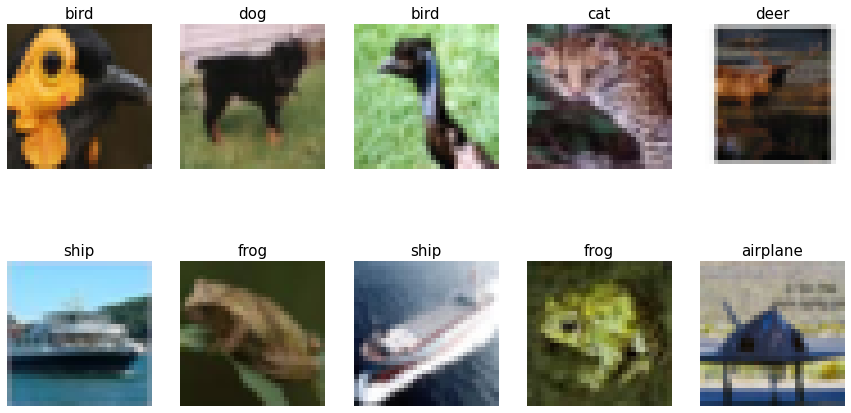

In [9]:
phases = ['train', 'test']
transform = T.Compose([T.Resize((32, 32)), T.ToTensor()])
cifar10_dataset = {
    phase: D.CIFAR10(
        'data', train=phase=='train', transform=transform, download=True
    )
    for phase in phases
}
loader = {
    phase: DataLoader(
        cifar10_dataset[phase],
        batch_size=batch_size,
        shuffle=phase=='train'
    )
    for phase in ['train', 'test']
}
images, target = sample_random_data(cifar10_dataset['train'])
titles = [cifar10_dataset['train'].classes[idx] for idx in target]
show_images(images.permute(0,2,3,1), titles)

### Data Augmentation

In [10]:
data_augmentation = True

dataset = get_cifar10_dataset(random_crop=data_augmentation)
loader = make_dataloader(dataset, batch_size)

Files already downloaded and verified


# Learning rate scheduling
- gamma: 한 epoch당 얼만큼 줄일 것인가. 숫자가 낮을수록 빠르게 줄어듦

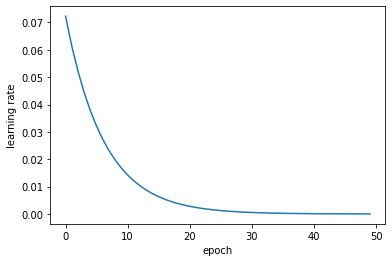

In [18]:
gamma = 0.85
lrs = simulate_scheduler(gamma, num_epochs)
plt.plot(lrs)
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

In [19]:
model = MyCNN().to(device)
optimizer = torch.optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma)

pp = ProgressPlot(
    plot_names=phases,
    line_names=['loss', 'accuracy'],
    x_lim=[0, None],
    x_label='Iteration',
    y_lim=[[0, None], [0, 100]]
)

accuracy = 0
for epoch in range(num_epochs):
    for inputs, target in loader['train']:
        loss = train_step(model, inputs, target, optimizer, criterion, device)
        pp.update([[loss, -1], [-500, accuracy]])
    
    corrects = 0
    for inputs, target in loader['test']:
        output, _ = test_step(model, inputs, target, device=device)
        corrects += (output.argmax(1).cpu() == target).sum().item()
    accuracy = corrects / len(dataset['test']) * 100
    
    print(f'Epoch: {epoch+1} accuracy {accuracy:.2f}')
pp.finalize()

Output hidden; open in https://colab.research.google.com to view.